**Import Tensorflow as Neural Network package**

In [2]:
import random
import pandas as pd 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import tensorflow as tf

random.seed(11)
np.random.seed(11)

In [3]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.18.0


In [4]:
Target = pd.read_csv("../../../4 - Data/04_WorkingDatasets/02 NormalCombLagged/TargetOutliersTreated.csv")
Data = pd.read_csv("../../../4 - Data/04_WorkingDatasets/02 NormalCombLagged/WDFCombLagged.csv")

In [5]:
Target.head()

#Data.drop(columns = ['Datum'], inplace = True)
Data.head()


,Datum,Rebgassechange,Clarahuuschange,Citychange,Storchenchange,Post Baselchange,Aeschenchange,Bahnhof Südchange,Bad. Bahnhofchange,Europechange,...,Basel Wind Speed [10 m]_x_Basel Wind Speed [10 m],Basel Wind Speed [10 m]_x_Basel Wind Direction [10 m],Basel Wind Speed [10 m]_x_Gasverbrauch,Basel Wind Speed [10 m]_x_Hour,Basel Wind Direction [10 m]_x_Basel Wind Direction [10 m],Basel Wind Direction [10 m]_x_Hour,406v_sumLW_x_408n_sumLief,660n_sumPW_x_Gasverbrauch,Gasverbrauch_x_Gasverbrauch,Gasverbrauch_x_Hour
0,2022-01-01 00:00:00+00:00,-0.069723,-0.000039,-0.010908,-0.175172,0.000008,0.000005,-0.245170,-0.052815,-0.000129,...,-0.235434,-0.283734,-0.377593,-0.046808,-0.890521,-0.020069,-0.122035,-0.459651,-0.612347,0.040175
1,2022-01-01 01:00:00+00:00,0.000222,-0.000039,-0.000018,0.000017,0.000008,0.000005,0.000040,-0.000251,-0.000129,...,-0.075257,-0.241799,-0.515062,-0.115922,-0.900547,-0.016733,0.086553,-0.576248,-0.585116,0.067887
2,2022-01-01 02:00:00+00:00,0.000222,-0.000039,-0.000018,-0.058380,0.000008,0.000005,0.490459,0.104878,-0.000129,...,-0.122800,-0.053188,-0.517671,-0.175949,-0.884203,-0.040232,-0.007376,-0.590613,-0.571382,0.099923
3,2022-01-01 03:00:00+00:00,0.000222,-0.000039,0.010872,0.058413,0.000008,0.000005,0.245250,0.104878,0.150828,...,-0.142698,-0.186471,-0.720133,-0.234521,-0.902521,-0.021412,0.156083,-0.692110,-0.417436,0.183681
4,2022-01-01 04:00:00+00:00,0.140113,-0.000039,0.903873,-0.058380,0.382243,0.000005,0.000040,-0.157943,0.150828,...,-0.239306,-0.076720,-0.998149,-0.253919,-0.882844,-0.061861,0.258004,-0.788389,0.146464,0.384286


In [6]:
#Lag Feature einbauen, da die Feinstaubkonzentration häufig von den Werten der letzten Tage abhängt 
#lag_hours = 24

# Erstelle für jede Stunde in der Vergangenheit eine Lag-Feature-Spalte
#for lag in range(1, lag_hours + 1):  
#    Data[f'Feature_lag_{lag}'] = Target['PM10_Combined_Trend_Residual'].shift(lag)

# Entfernen von Zeilen mit NaN-Werten, die durch das Verschieben der Daten entstehen
#Data.dropna(inplace=True)
# Stelle sicher, dass du NaN-Werte aus beiden X und y entfernst

# Stelle sicher, dass Target denselben Index hat wie Data
#Target = Target.loc[Data.index]

Data = Data[Data['Datum'] >= '2022-01-02 01:00:00+00:00']
Data.drop(columns = ['Datum'], inplace = True)

Target = Target[Target['Datum'] <= '2024-10-19 20:00:00+00:00']


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Data = scaler.fit_transform(Data)

In [8]:
tf.random.set_seed(11)

# Beispiel: Annahme, X.shape[0] = 1000 (1000 Zeitpunkte)
n = Data.shape[0]
X = Data.copy()
y = Target["PM10_Combined_Trend_Residual"].copy()

# Split-Größen definieren
train_size = int(n * 0.7)  # 70% Training
val_size = int(n * 0.1)    # 10% Validierung
test_size = n - train_size - val_size  # 20% Test

# Training (älteste Daten)
X_train, y_train = X[:train_size], y[:train_size]

# Validierung (neuere Daten)
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]

# Test (neueste Daten)
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


In [8]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [10]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])


Epoch 1/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 41.1428 - mae: 3.9190 - mse: 35.9824 - val_loss: 21.5930 - val_mae: 2.4072 - val_mse: 17.5014
Epoch 2/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.1446 - mae: 2.3181 - mse: 10.3740 - val_loss: 19.2256 - val_mae: 2.2542 - val_mse: 16.3081
Epoch 3/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.3667 - mae: 2.1193 - mse: 8.6697 - val_loss: 18.8758 - val_mae: 2.3512 - val_mse: 16.7375
Epoch 4/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.0389 - mae: 2.0326 - mse: 8.0435 - val_loss: 18.3180 - val_mae: 2.2786 - val_mse: 16.6520
Epoch 5/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.6546 - mae: 2.0098 - mse: 8.0755 - val_loss: 17.0484 - val_mae: 2.2533 - val_mse: 15.6641
Epoch 6/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.0544 - mae: 1.9649 - mse: 7.7308 - val_loss: 17.1743 - val_mae: 2.2363 - val_mse: 15.9825
Epoch 7/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8

In [12]:
print(X_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in X_test
print(y_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in y_test


(2454, 183)
(2454,)


In [13]:
results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7846 - mae: 1.5166 - mse: 4.7224  
Test loss, Test MAE: [6.13178825378418, 1.6000216007232666, 5.069531440734863]


In [23]:
tf.random.set_seed(11)

model2 = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model2.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 48.0652 - mae: 4.3601 - mse: 42.8811 - val_loss: 23.5217 - val_mae: 2.6491 - val_mse: 19.3870
Epoch 2/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 16.3329 - mae: 2.5875 - mse: 12.4898 - val_loss: 20.7083 - val_mae: 2.3882 - val_mse: 17.6541
Epoch 3/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13.5933 - mae: 2.4335 - mse: 10.7484 - val_loss: 18.9068 - val_mae: 2.2884 - val_mse: 16.5954
Epoch 4/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.4933 - mae: 2.3356 - mse: 10.3155 - val_loss: 18.0315 - val_mae: 2.2059 - val_mse: 16.1714
Epoch 5/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.0016 - mae: 2.3049 - mse: 10.2318 - val_loss: 16.7475 - val_mae: 2.0969 - val_mse: 15.1964
Epoch 6/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 11.6221 - mae: 2.2954 - mse: 10.1305 - val_loss: 16.1308 - val_mae: 2.0119 - val_mse: 14.7711
Epoch 7/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10.7137

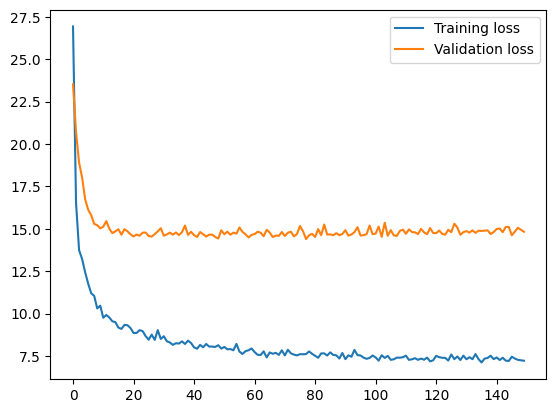

In [24]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [25]:
tf.random.set_seed(11)

model3 = Sequential([
    Dense(512, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.15),
    Dense(256, activation='relu'),
    Dropout(0.38),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.38, patience=10, min_lr=1e-6) # Vorschläge aus dem Internet testen



history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model3.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)

Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1073/1073 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 36.5709 - mae: 3.5614 - mse: 30.3072 - val_loss: 21.1402 - val_mae: 2.3220 - val_mse: 16.7749
Epoch 2/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 13.2842 - mae: 2.2236 - mse: 9.4224 - val_loss: 19.6064 - val_mae: 2.3244 - val_mse: 16.9105
Epoch 3/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10.9725 - mae: 2.1072 - mse: 8.5186 - val_loss: 17.8200 - val_mae: 2.1965 - val_mse: 15.9261
Epoch 4/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.7246 - mae: 2.0323 - mse: 7.9538 - val_loss: 17.8590 - val_mae: 2.2736 - val_mse: 16.3647
Epoch 5/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.3786 - mae: 2.0243 - mse: 7.9519 - val_loss: 18.0721 - val_mae: 2.3381 - val_mse: 16.7917
Epoch 6/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.6422 - mae: 1.9448 - mse: 7.4163 - val_loss: 16.4205 - val_mae: 2.1601 - val_mse: 15.3049
Epoch 7/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.4172 - mae: 1

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7661 - mae: 1.4841 - mse: 4.2201  
Test loss, Test MAE: [5.42454195022583, 1.6282896995544434, 4.878493785858154]

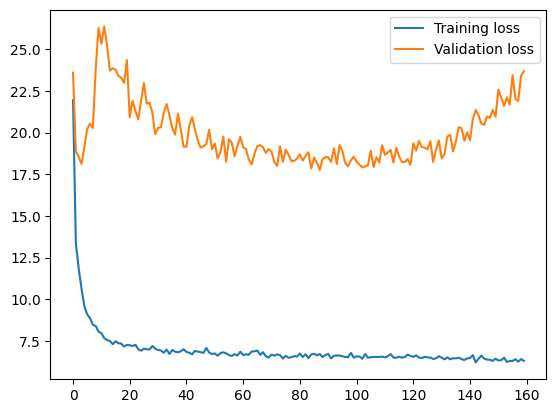

In [17]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


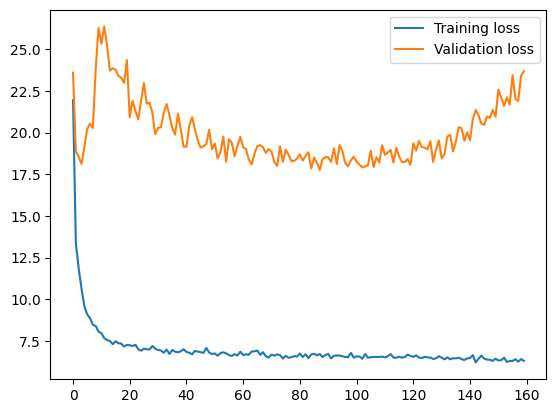

In [18]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [ ]:
tf.random.set_seed(11)

model4 = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.15),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model4.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)


history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model4.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)



Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 44.9924 - mae: 4.1524 - mse: 39.8337 - val_loss: 21.9652 - val_mae: 2.6235 - val_mse: 18.3233
Epoch 2/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10.7805 - mae: 1.9510 - mse: 7.5145 - val_loss: 18.5269 - val_mae: 2.2183 - val_mse: 16.1637
Epoch 3/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.8585 - mae: 1.8367 - mse: 6.7084 - val_loss: 17.3043 - val_mae: 2.1376 - val_mse: 15.6259
Epoch 4/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.0851 - mae: 1.7892 - mse: 6.5188 - val_loss: 16.3663 - val_mae: 2.0494 - val_mse: 15.0575
Epoch 5/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4390 - mae: 1.7485 - mse: 6.2016 - val_loss: 15.7776 - val_mae: 2.0036 - val_mse: 14.7032
Epoch 6/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2763 - mae: 1.7561 - mse: 6.2443 - val_loss: 15.3951 - val_mae: 1.9627 - val_mse: 14.4608
Epoch 7/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.9228 - mae: 1.